In [117]:
import jax
import flax
import jax.numpy as jnp
import numpy as np
import optax
from jax import grad, jit, vmap, pmap

from jax import random
from copy import deepcopy
from typing import Tuple, NamedTuple
import functools
import typing
import copy
import matplotlib.pyplot as plt

from torchvision.datasets import MNIST
from torch.utils.data import DataLoader

In [ ]:
seed = 0
def init_mlp(layer_width, key):
  params = []
  keys = jax.random.split(key, num=len(layer_width)-1)
  for input, out, this_key in zip(layer_width[:-1], layer_width[1:], keys):
    weight_key, bias_key = jax.random.split(this_key)
    params.append([jax.random.normal(weight_key, shape=(out, input)) * 0.01, jax.random.normal(bias_key,shape=(out,)) * 0.01])
  return params

key = jax.random.PRNGKey(seed)
mlp_param = init_mlp([784, 512, 256, 10], key)
print(jax.tree.map(lambda x: print(x), param[-1]))

In [ ]:
def mlp_predict(params, x):
  hidden_layers = params[:-1]
  activation = x;
  for w, b in hidden_layers:
    activation = jnp.dot(w, activation) + b
    activation = jax.nn.relu(activation)
  w, b = params[-1]
  # return the logits (logits is unnomalized log probaility)
  logits = jnp.dot(w, activation) + b
  return logits

batched_mlp_predict = jax.vmap(mlp_predict, in_axes=(None, 0))

mnist_img_size = (28,28)
dummy_imgs_flat = np.random.randn(16, np.prod(mnist_img_size))
# print(dummy_imgs_flat.shape)
predictions = batched_mlp_predict(mlp_param, dummy_imgs_flat)

In [112]:
train_dataset = MNIST(root='.', train=True, download=True, transform=lambda x: np.ravel(np.array(x, dtype=np.float32)))
test_dataset = MNIST(root='.', train=False, download=True, transform=lambda x: np.ravel(np.array(x, dtype=np.float32)))
batch_size = 256

def custom_collate_fn(batch):

    # >>> s1 = {2, 3, 1}
    # >>> s2 = {'b', 'a', 'c'}
    # >>> list(zip(s1, s2))
    # [(1, 'a'), (2, 'c'), (3, 'b')]
    # * upacking operator
    transposed_data = list(zip(*batch))

    labels = np.array(transposed_data[1])
    imgs = np.stack(transposed_data[0])
    return imgs, labels

train_loader = DataLoader(train_dataset, batch_size, shuffle=True, collate_fn=custom_collate_fn, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size, shuffle=False, collate_fn=custom_collate_fn, drop_last=True)

In [ ]:
batch_data = next(iter(train_loader))

# Turn index into one hot vectors or just use jax.nn.onehot
# a = np.array([1, 0, 3])
# b = np.zeros((a.size, a.max() + 1))
# b[np.arange(a.size), a] = 1

In [ ]:
num_epochs = 10
def loss_fn(params, imgs, labels):
    predictions = batched_mlp_predict(params, imgs)
    loss = optax.softmax_cross_entropy_with_integer_labels(predictions, labels)
    loss = jnp.mean(loss)
    return loss

def update(params, imgs, labels):
  lr = 0.01
  loss = loss_fn(params, imgs, labels)
  grad = jax.grad(loss_fn)(params, imgs, labels)
  # print(grad)
  params = jax.tree.map(lambda x, y: x - 0.01 * y, params, grad)
  return loss, params

for epoch in range(num_epochs):
  for imgs, labels in train_loader:
    loss, mlp_param = update(mlp_param, imgs, labels)
    print(loss)

8 8
6 6
7 7
0 0
3 3
2 2
5 5
9 9
2 2
7 7
3 3
8 8
4 4
3 9


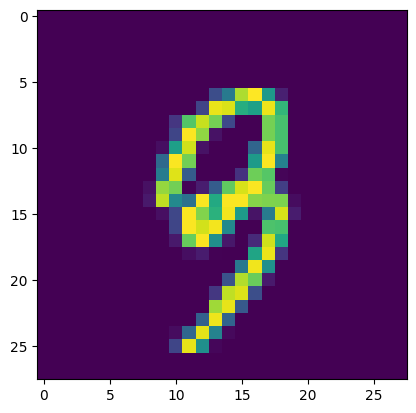

8 8
5 5
7 7
7 7
5 5
9 9
7 7
2 2
8 8
3 3
1 1
7 7
6 6
3 3
6 6
8 8


In [123]:
batch_data = next(iter(train_loader))
imgs, labels = batch_data

for i in range(30):
  img = imgs[i]
  predict = jnp.argmax(mlp_predict(mlp_param, img))
  print(labels[i], predict)
  if labels[i] != predict:
    img = img.reshape(28,28)
    plt.imshow(img)
    plt.show()
